## Homework 11 EM clustering for Multivariate Gaussians

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from math import sqrt, log, exp, pi
from random import uniform
from scipy.special import logsumexp
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_samples=500, n_features=2, shuffle=True, random_state=40)

In [2]:
class Gaussian:
    "Model multivariate Gaussian"
    def __init__(self, mu, cov):
        #mean and standard deviation
        self.mu = mu
        self.cov = cov

    #probability density function
    def pdf(self, x):
        "Probability of a data point given the current parameters"
        "You can modify def _predict(self, x): in Lecture 09_2_BayesClassifier_oop.jpynb "
        inner = np.dot((x - self.mu),np.linalg.inv(self.cov))
        inner = np.dot(inner,(x - self.mu).T) 

        numerator = np.exp(-0.5*inner)
        denominator = np.sqrt((2 * np.pi)**len(x) * np.abs(np.linalg.det(self.cov)))

        return numerator / denominator
    
    def __repr__(self):
        return 'Gaussian([{0:4.4},{1:4.4}],[[{2:4.4},{3:4.4}],[{4:4.4},{5:4.4}]])'.format(self.mu[0], 
                                                                                       self.mu[1], 
                                                                                       self.cov[0,0],
                                                                                       self.cov[0,1],
                                                                                       self.cov[1,0],
                                                                                       self.cov[1,1],)
print("done")

done


In [3]:
class GaussianMixture_self:
    "Model mixture of two multivariate Gaussians and their EM estimation"

    def __init__(self, data, K=2, mix=.5):
        self.data = data
        mu_min=data.min(0) #沿垂直方向找最小值 1 x 2
        mu_max=data.max(0) #沿垂直方向找最大值 1 x 2
        cov= np.identity(data.shape[1])
        
        # Algorithm would be numerical enhanced by normalizing the data first, 
        # next do all the EM steps and do the de-normalising at the end
        
        # init with multiple gaussians
        # uniform(x,y): 在[x,y]之間隨機產生一個數字，產生的pdf是1/(y-x)
        
        self.one = Gaussian([uniform(mu_min[0], mu_max[0]), uniform(mu_min[1], mu_max[1])], cov)
        self.two = Gaussian([uniform(mu_min[0], mu_max[0]), uniform(mu_min[1], mu_max[1])], cov)
        
        #as well as how much to mix them
        self.mix = mix
        
        # number of clusters
        self.K = K        
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        
    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators    
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, self.data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, self.data))
        
        
        # compute new sigmas, 
        # You need to make sure that two 2 x 2 covarances are computed correctly
        self.one.cov = np.zeros((2,2))
        self.two.cov = np.zeros((2,2))
        
        for (w, d) in zip(left, self.data):
            diff = np.reshape((d - self.one.mu), (2,1))
            self.one.cov += w * np.dot(diff, diff.T) / one_den
            
        for (w, d) in zip(rigt, self.data):
            diff = np.reshape((d - self.two.mu), (2,1))
            self.two.cov += w * np.dot(diff, diff.T) / two_den

        # compute new mix
        self.mix = one_den / len(self.data)
        
        
    def iterate(self, N=10, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep()
        
    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
    
    def create_clusters(self):
        # Assign the samples to the closest centroids (means of Gaussian) to create clusters
        # You need to combine def _create_clusters and def _closest_centroid in
        # Lecture 05_1 kmeans_oop.jpynb
        
        clusters = [[] for _ in range(self.K)]
        
        def _closest_centroid(sample):
            dist1 = np.linalg.norm(sample - self.one.mu)
            dist2 = np.linalg.norm(sample - self.two.mu)
            return 0 if dist1 < dist2 else 1
        
        for idx, sample in enumerate(self.data):
            centroid_idx = _closest_centroid(sample)
            clusters[centroid_idx].append(idx)
        return clusters
        
    def plot(self):
        self.clusters = self.create_clusters()
        
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(self.data[self.clusters[0], 0], self.data[self.clusters[0], 1],
                   c='green', marker='o', label='cluster 1')
        ax.scatter(self.data[self.clusters[1], 0], self.data[self.clusters[1], 1],
                     c='blue', marker='o', label='cluster 2')
        ax.legend()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Plot of data points and cluster centroids')
        ax.plot(self.one.mu[0], self.one.mu[1], c='red', marker='x')
        ax.plot(self.two.mu[0], self.two.mu[1], c='red', marker='x')

        plt.show()        
    
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2:1.4})'.format(self.one, self.two, self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:1.4})'.format(self.one, self.two, self.mix)
print("done")

done


 1 Mixture: Gaussian([-0.7963,-8.22],[[7.836,2.879],[2.879,2.501]]), Gaussian([2.396,-3.81],[[12.3,-0.2644],[-0.2644,0.646]]), mix=0.4212)
 2 Mixture: Gaussian([-1.226,-8.494],[[5.129,1.983],[1.983,1.992]]), Gaussian([2.456,-3.925],[[12.53,-0.3756],[-0.3756,0.7829]]), mix=0.3813)
 3 Mixture: Gaussian([-1.672,-8.753],[[2.264,0.6253],[0.6253,1.231]]), Gaussian([2.533,-3.989],[[12.47,-0.4599],[-0.4599,0.8597]]), mix=0.3522)
 4 Mixture: Gaussian([-1.852,-8.853],[[1.173,0.1467],[0.1467,0.9563]]), Gaussian([2.548,-4.025],[[12.37,-0.4914],[-0.4914,0.9278]]), mix=0.34)
 5 Mixture: Gaussian([-1.863,-8.873],[[1.139,0.1172],[0.1172,0.9027]]), Gaussian([2.539,-4.032],[[12.36,-0.475],[-0.475,0.9382]]), mix=0.3378)
 6 Mixture: Gaussian([-1.864,-8.877],[[1.139,0.1149],[0.1149,0.8924]]), Gaussian([2.536,-4.033],[[12.37,-0.4691],[-0.4691,0.9409]]), mix=0.3373)
 7 Mixture: Gaussian([-1.864,-8.877],[[1.139,0.1145],[0.1145,0.8904]]), Gaussian([2.535,-4.034],[[12.37,-0.4678],[-0.4678,0.9415]]), mix=0.3372)

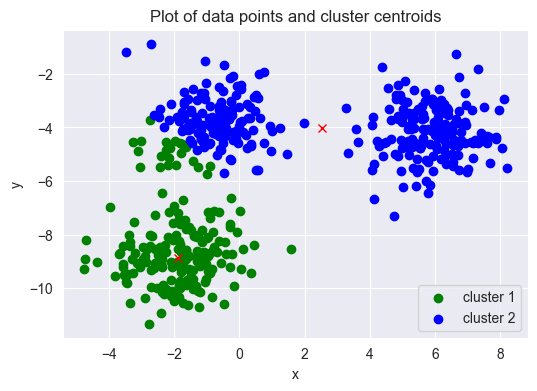

In [4]:
n_iterations = 2
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(X)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
            
    # Catch division errors from bad starts, and just throw them out...    
    except (ZeroDivisionError, ValueError, RuntimeWarning): 
        print("one less")
        pass

mix.plot()

Computing best model with random restarts...

 1 Mixture: Gaussian([-0.08574,-8.092],[[12.14, 5.2],[ 5.2,3.045]]), Gaussian([1.906,-3.846],[[11.78,0.3328],[0.3328,0.7797]]), mix=0.4289)
 2 Mixture: Gaussian([-0.4506,-8.211],[[10.09,4.404],[4.404,2.855]]), Gaussian([2.103,-3.887],[[12.19,0.009208],[0.009208,0.79]]), mix=0.4116)
 3 Mixture: Gaussian([-0.8818,-8.403],[[7.536,3.192],[3.192,2.343]]), Gaussian([2.282,-3.926],[[12.43,-0.1889],[-0.1889,0.8074]]), mix=0.3889)
 4 Mixture: Gaussian([-1.378,-8.643],[[4.33,1.595],[1.595,1.591]]), Gaussian([2.439,-3.968],[[12.51,-0.341],[-0.341,0.8368]]), mix=0.3635)
 5 Mixture: Gaussian([-1.76,-8.823],[[1.743,0.3594],[0.3594,1.022]]), Gaussian([2.529,-4.008],[[12.44,-0.4511],[-0.4511,0.8865]]), mix=0.3445)
 6 Mixture: Gaussian([-1.861,-8.869],[[1.143,0.1245],[0.1245,0.9131]]), Gaussian([2.541,-4.03],[[12.37,-0.4795],[-0.4795,0.9352]]), mix=0.3383)
 7 Mixture: Gaussian([-1.864,-8.876],[[1.139,0.1154],[0.1154,0.8945]]), Gaussian([2.537,-4.033],[[12.3

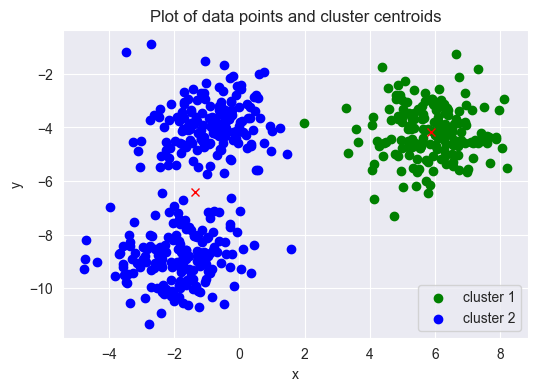

In [5]:
# Find best Mixture Gaussian model
n_iterations = 30
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(X)
    for _ in range(n_iterations):
        try:
            mix.iterate(verbose=True)
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
        
best_mix.plot()